<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/%5B1%5D_ODE_PINN_ClassForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optax
!pip install pytreeclass
!pip install tqdm

In [2]:
# Imports
from __future__ import annotations
from typing import Callable
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import sympy as sp
import pytreeclass as pytc
from tqdm.notebook import tqdm

### Generate a a differential equation and its solution using SymPy

In [3]:
t= sp.symbols('t')
f = sp.Function('y')
diffeq = sp.Eq(f(t).diff(t,t) + f(t).diff(t)-t*sp.cos(2*sp.pi*t),0)
sol = sp.simplify(sp.dsolve(diffeq,ics={f(0):1,f(t).diff(t).subs(t,0):10}).rhs)

In [4]:
diffeq

Eq(-t*cos(2*pi*t) + Derivative(y(t), t) + Derivative(y(t), (t, 2)), 0)

In [5]:
sp.Eq(f(t).diff(t).subs(t,0),10)

Eq(Subs(Derivative(y(t), t), t, 0), 10)

In [6]:
sp.Eq(f(t).subs(t,0),1)

Eq(y(0), 1)

In [7]:
sp.Eq(f(t),sol)

Eq(y(t), (2*pi*t*exp(t)*sin(2*pi*t) + 8*pi**3*t*exp(t)*sin(2*pi*t) - 16*pi**4*t*exp(t)*cos(2*pi*t) - 4*pi**2*t*exp(t)*cos(2*pi*t) + 16*pi**3*exp(t)*sin(2*pi*t) + exp(t)*cos(2*pi*t) + 12*pi**2*exp(t)*cos(2*pi*t) - exp(t) + 36*pi**2*exp(t) + 336*pi**4*exp(t) + 704*pi**6*exp(t) - 640*pi**6 - 304*pi**4 - 44*pi**2)*exp(-t)/(4*pi**2*(1 + 8*pi**2 + 16*pi**4)))

In [8]:
#verify solution
sp.simplify(-t*sp.cos(sp.pi*2*t)+sol.diff(t)+sol.diff(t,t))

0

### Constructing the MLP

In [9]:
# construct data

N_b = 1
N_c = 100

tmin, tmax = 0.0, jnp.pi

"""boundary conditions"""


# U[0] = 1
t_0 = jnp.ones([N_b, 1], dtype="float32") * 0.0
ic_0 = jnp.ones_like(t_0)
IC_0 = jnp.concatenate([t_0, ic_0], axis=1)

# U_t[0] = 10
t_b1 = jnp.zeros([N_b, 1])
bc_1 = jnp.ones_like(t_b1) * 10
BC_1 = jnp.concatenate([t_b1, bc_1], axis=1)

conds: list[jax.Array] = [IC_0, BC_1]

# collocation points

key = jax.random.PRNGKey(0)

t_c = jax.random.uniform(key, minval=tmin, maxval=tmax, shape=(N_c, 1))
colloc = t_c

# Build Model

In [10]:
init_func = jax.nn.initializers.glorot_uniform()


class Linear(pytc.TreeClass):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        key: jax.random.KeyArray = jax.random.PRNGKey(0),
    ):
        self.weight = init_func(key, (in_features, out_features))
        self.bias = jax.numpy.zeros((out_features,))

    def __call__(self, x: jax.Array) -> jax.Array:
        return x @ self.weight + self.bias


class MLP(pytc.TreeClass):
    def __init__(self, key: jax.random.KeyArray = jax.random.PRNGKey(0)):
        k1, k2, k3, k4 = jax.random.split(key, 4)
        self.l1 = Linear(1, 20, key=k1)
        self.l2 = Linear(20, 20, key=k2)
        self.l3 = Linear(20, 20, key=k3)
        self.l4 = Linear(20, 1, key=k4)

    def __call__(self, x: jax.Array) -> jax.Array:
        x = self.l1(x)
        x = jax.nn.tanh(x)
        x = self.l2(x)
        x = jax.nn.tanh(x)
        x = self.l3(x)
        x = jax.nn.tanh(x)
        x = self.l4(x)
        return x


model = MLP()
print(pytc.tree_summary(model))

┌──────────┬──────────┬─────┬──────┐
│Name      │Type      │Count│Size  │
├──────────┼──────────┼─────┼──────┤
│.l1.weight│f32[1,20] │20   │80.00B│
├──────────┼──────────┼─────┼──────┤
│.l1.bias  │f32[20]   │20   │80.00B│
├──────────┼──────────┼─────┼──────┤
│.l2.weight│f32[20,20]│400  │1.56KB│
├──────────┼──────────┼─────┼──────┤
│.l2.bias  │f32[20]   │20   │80.00B│
├──────────┼──────────┼─────┼──────┤
│.l3.weight│f32[20,20]│400  │1.56KB│
├──────────┼──────────┼─────┼──────┤
│.l3.bias  │f32[20]   │20   │80.00B│
├──────────┼──────────┼─────┼──────┤
│.l4.weight│f32[20,1] │20   │80.00B│
├──────────┼──────────┼─────┼──────┤
│.l4.bias  │f32[1]    │1    │4.00B │
├──────────┼──────────┼─────┼──────┤
│Σ         │MLP       │901  │3.52KB│
└──────────┴──────────┴─────┴──────┘


In [11]:
def mse(true, pred):
    return jnp.mean((true - pred) ** 2)


def diff(func: Callable, *args, **kwargs):
    """sum then grad"""
    return jax.grad(lambda *ar, **kws: jnp.sum(func(*ar, **kws)), *args, **kwargs)


def ode_loss(t, u):
    u_t = diff(u)
    u_tt = diff(u_t)
    return -t * jnp.cos(2 * jnp.pi * t) + u_t(t) + u_tt(t)


def loss_func(model, colloc, conds):
    t_c = colloc[:, [0]]
    ufunc = model
    ufunc_t = diff(model)

    loss = jnp.mean(ode_loss(t_c, ufunc) ** 2)

    t_ic, u_ic = conds[0][:, [0]], conds[0][:, [1]]
    loss += mse(u_ic, ufunc(t_ic))

    t_bc, u_bc = conds[1][:, [0]], conds[1][:, [1]]
    loss += mse(u_bc, ufunc_t(t_bc))

    return loss


optim = optax.adam(1e-3)
optim_state = optim.init(model)


@jax.jit
def train_step(
    model: MLP,
    optim_state: optax.OptState,
    colloc: jax.Array,
    conds: list[jax.Array],
):
    # Get the gradient w.r.t to MLP params
    grads = jax.grad(loss_func)(model, colloc, conds)

    # Update model
    updates, optim_state = optim.update(grads, optim_state)
    model = optax.apply_updates(model, updates)

    return model, optim_state

In [12]:
%%time
epochs = 10_000
for _ in tqdm(range(1,epochs+1)):
  model,optim_state = train_step(model, optim_state,colloc,conds)

  # print loss and epoch info
  if _ %(100) ==0:
    print(f'Epoch={_}\tloss={loss_func(model,colloc,conds):.3e}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch=100	loss=7.777e+00
Epoch=200	loss=4.808e+00
Epoch=300	loss=3.418e+00
Epoch=400	loss=2.729e+00
Epoch=500	loss=2.319e+00
Epoch=600	loss=2.135e+00
Epoch=700	loss=2.059e+00
Epoch=800	loss=2.009e+00
Epoch=900	loss=1.959e+00
Epoch=1000	loss=1.902e+00
Epoch=1100	loss=1.841e+00
Epoch=1200	loss=1.779e+00
Epoch=1300	loss=1.719e+00
Epoch=1400	loss=1.666e+00
Epoch=1500	loss=1.620e+00
Epoch=1600	loss=1.566e+00
Epoch=1700	loss=1.475e+00
Epoch=1800	loss=1.291e+00
Epoch=1900	loss=1.112e+00
Epoch=2000	loss=8.120e-01
Epoch=2100	loss=1.764e-01
Epoch=2200	loss=1.382e-02
Epoch=2300	loss=5.528e-03
Epoch=2400	loss=4.135e-03
Epoch=2500	loss=3.343e-03
Epoch=2600	loss=2.765e-03
Epoch=2700	loss=2.345e-03
Epoch=2800	loss=2.044e-03
Epoch=2900	loss=1.826e-03
Epoch=3000	loss=1.662e-03
Epoch=3100	loss=1.533e-03
Epoch=3200	loss=1.427e-03
Epoch=3300	loss=1.335e-03
Epoch=3400	loss=1.254e-03
Epoch=3500	loss=1.180e-03
Epoch=3600	loss=1.113e-03
Epoch=3700	loss=1.050e-03
Epoch=3800	loss=9.922e-04
Epoch=3900	loss=9.382

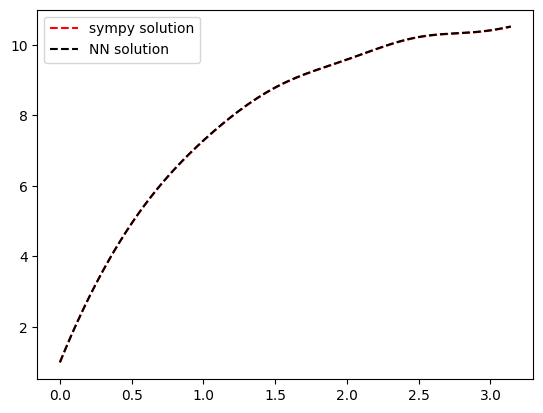

In [13]:
lam_sol= sp.lambdify(t,sol)

dT = 1e-3
Tf = jnp.pi
T = np.arange(0,Tf+dT,dT)


sym_sol =np.array([lam_sol(i) for i in T])

plt.plot(T,sym_sol,'--r',label='sympy solution')
plt.plot(T,model(T.reshape(-1,1))[:,0],'--k',label='NN solution')
plt.legend()